In [1]:
import keras
keras.__version__

/home/leechan/anaconda3/envs/DLCNN/lib/python3.5/site-packages/h5py/__init__.py:36: FutureWarning: Conversion of the second argument of issubdtype from `float` to `np.floating` is deprecated. In future, it will be treated as `np.float64 == np.dtype(float).type`.
  from ._conv import register_converters as _register_converters
Using TensorFlow backend.


'2.1.5'

In [2]:
from keras.applications import inception_v3
from keras.layers import Lambda 
from keras.models import Input

input_tensor = Input((299, 299, 3))
x = input_tensor
x = Lambda(inception_v3.preprocess_input)(x)

conv_base = inception_v3.InceptionV3(weights='imagenet',
                                     include_top=False,
                                     input_tensor=x)

In [3]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [4]:
import os
import numpy as np
from keras.preprocessing.image import ImageDataGenerator

base_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base'
train_dir = os.path.join(base_dir, 'train_dir')
validation_dir = os.path.join(base_dir, 'validation_dir')

test_dir = '/home/leechan/Documents/Capstone_Dog vs. Cats/Project_Dogs_vs_Cats/Dataset_Dogs_vs_Cats/base/test_dir'

datagen = ImageDataGenerator()
batch_size = 15

def extract_features(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    labels = np.zeros(shape=(sample_count))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='binary')
    i = 0
    for inputs_batch, labels_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        labels[i * batch_size : (i + 1) * batch_size] = labels_batch
        i += 1
        if i * batch_size >= sample_count:
            # Note that since generators yield data indefinitely in a loop,
            # we must `break` after every image has been seen once.
            break
    return features, labels

def extract_features_test(directory, sample_count):
    features = np.zeros(shape=(sample_count, 8, 8, 2048))
    generator = datagen.flow_from_directory(
        directory,
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode=None)
    i = 0
    for inputs_batch in generator:
        features_batch = conv_base.predict(inputs_batch)
        features[i * batch_size : (i + 1) * batch_size] = features_batch
        i += 1
        if i * batch_size >= sample_count:
            break
            
    return features

#test_features = extract_features_test(test_dir, 12500)
train_features, train_labels = extract_features(train_dir, 20000)
validation_features, validation_labels = extract_features(validation_dir, 5000)

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [5]:
train_features = np.reshape(train_features, (20000, 8 * 8 * 2048))
validation_features = np.reshape(validation_features, (5000, 8 * 8 * 2048))
#test_features = np.reshape(test_features, (12500, 1 * 1 * 2048))

In [8]:
from keras import models
from keras import layers
from keras import optimizers

model = models.Sequential()
model.add(layers.Dense(1024, activation='relu', input_dim=8 * 8 * 2048))
model.add(layers.Dropout(0.5))
model.add(layers.Dense(1, activation='sigmoid'))

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

In [9]:
history = model.fit(train_features, train_labels,
                    epochs=30,
                    batch_size=120,
                    validation_data=(validation_features, validation_labels))

Train on 20000 samples, validate on 5000 samples
Epoch 1/30
20000/20000 [==============================] - 23s 1ms/step - loss: 0.1229 - acc: 0.9751 - val_loss: 0.0485 - val_acc: 0.9880
Epoch 2/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0304 - acc: 0.9928 - val_loss: 0.0583 - val_acc: 0.9912
Epoch 3/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0219 - acc: 0.9953 - val_loss: 0.0574 - val_acc: 0.9918
Epoch 4/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0186 - acc: 0.9962 - val_loss: 0.0673 - val_acc: 0.9914
Epoch 5/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0132 - acc: 0.9971 - val_loss: 0.0717 - val_acc: 0.9922
Epoch 6/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0090 - acc: 0.9982 - val_loss: 0.0634 - val_acc: 0.9922
Epoch 7/30
20000/20000 [==============================] - 22s 1ms/step - loss: 0.0107 - acc: 0.9985 - val_loss: 0.0722 - val_acc:

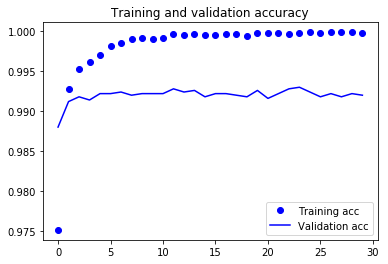

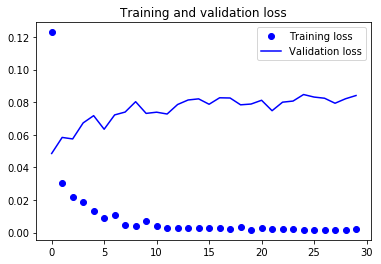

In [11]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [12]:
from keras.preprocessing import image
from keras.models import Model 
from keras.layers import Dense, GlobalAveragePooling2D, Flatten, Dropout
from keras import backend as K

x = conv_base.output
x = GlobalAveragePooling2D()(x)
x = Dropout(0.5)(x)
x = Dense(1024, activation='relu')(x)
predictions = Dense(1, activation='sigmoid')(x)

model = Model(inputs=conv_base.input, outputs=predictions)

In [13]:
print('This is the number of trainable weights '
      'before freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights before freezing the conv base: 192


In [14]:
for layer in conv_base.layers:
    layer.trainable = False

print('This is the number of trainable weights '
      'after freezing the conv base:', len(model.trainable_weights))

This is the number of trainable weights after freezing the conv base: 4


In [15]:
from keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(
      #rescale=1./255,
      rotation_range=30,
      width_shift_range=0.2,
      height_shift_range=0.2,
      shear_range=0.2,
      zoom_range=0.2,
      horizontal_flip=True,
      fill_mode='nearest')

# Note that the validation data should not be augmented!
test_datagen = ImageDataGenerator()

train_generator = train_datagen.flow_from_directory(
        # This is the target directory
        train_dir,
        # All images will be resized to 150x150
        target_size=(299, 299),
        batch_size=100,
        # Since we use binary_crossentropy loss, we need binary labels
        class_mode='binary')

validation_generator = test_datagen.flow_from_directory(
        validation_dir,
        target_size=(299, 299),
        batch_size=100,
        class_mode='binary')

Found 20000 images belonging to 2 classes.
Found 5000 images belonging to 2 classes.


In [17]:
from keras import optimizers

model.compile(optimizer=optimizers.RMSprop(lr=2e-5),
              loss='binary_crossentropy',
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=30,
      validation_data=validation_generator,
      validation_steps=50,
      verbose=2)

Epoch 1/50
 - 293s - loss: 0.2717 - acc: 0.9191 - val_loss: 0.1140 - val_acc: 0.9628
Epoch 2/50
 - 339s - loss: 0.1510 - acc: 0.9470 - val_loss: 0.0789 - val_acc: 0.9744
Epoch 3/50
 - 284s - loss: 0.1303 - acc: 0.9517 - val_loss: 0.0613 - val_acc: 0.9798
Epoch 4/50
 - 278s - loss: 0.1203 - acc: 0.9556 - val_loss: 0.0838 - val_acc: 0.9690
Epoch 5/50
 - 279s - loss: 0.1145 - acc: 0.9551 - val_loss: 0.0718 - val_acc: 0.9754
Epoch 6/50
 - 279s - loss: 0.1092 - acc: 0.9580 - val_loss: 0.1290 - val_acc: 0.9542
Epoch 7/50
 - 278s - loss: 0.1079 - acc: 0.9588 - val_loss: 0.0752 - val_acc: 0.9746
Epoch 8/50
 - 278s - loss: 0.1067 - acc: 0.9590 - val_loss: 0.0917 - val_acc: 0.9688
Epoch 9/50
 - 279s - loss: 0.1052 - acc: 0.9582 - val_loss: 0.0639 - val_acc: 0.9792
Epoch 10/50
 - 283s - loss: 0.1038 - acc: 0.9597 - val_loss: 0.0699 - val_acc: 0.9774
Epoch 11/50
 - 278s - loss: 0.1047 - acc: 0.9592 - val_loss: 0.0648 - val_acc: 0.9794
Epoch 12/50
 - 284s - loss: 0.1044 - acc: 0.9584 - val_loss: 0.

In [18]:
model.save('InceptionV3_feature_extraction.h5')

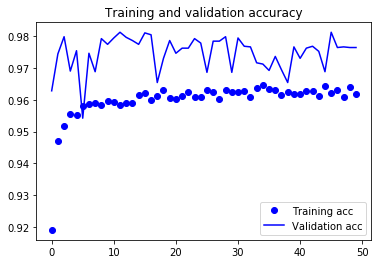

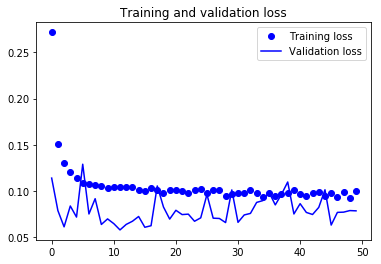

In [19]:
import matplotlib.pyplot as plt

acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()
plt.show()

In [20]:
conv_base.summary()

__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 299, 299, 3)  0                                            
__________________________________________________________________________________________________
lambda_1 (Lambda)               (None, 299, 299, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv2d_1 (Conv2D)               (None, 149, 149, 32) 864         lambda_1[0][0]                   
__________________________________________________________________________________________________
batch_normalization_1 (BatchNor (None, 149, 149, 32) 96          conv2d_1[0][0]                   
__________________________________________________________________________________________________
activation

In [21]:
for layer in model.layers[:249]:
    layer.trainable = False
for layer in model.layers[249:]:
    layer.trainable = True

In [22]:
from keras.callbacks import EarlyStopping

early_stopping = EarlyStopping(monitor='val_loss',patience=8)

model.compile(loss='binary_crossentropy',
              optimizer=optimizers.RMSprop(lr=1e-5),
              metrics=['acc'])

history = model.fit_generator(
      train_generator,
      steps_per_epoch=200,
      epochs=100,
      validation_data=validation_generator,
      validation_steps=50,
      callbacks=[early_stopping])

Epoch 1/100
200/200 [==============================] - 296s 1s/step - loss: 0.0812 - acc: 0.9672 - val_loss: 0.0238 - val_acc: 0.9926
Epoch 2/100
200/200 [==============================] - 281s 1s/step - loss: 0.0650 - acc: 0.9753 - val_loss: 0.0257 - val_acc: 0.9918
Epoch 3/100
200/200 [==============================] - 280s 1s/step - loss: 0.0599 - acc: 0.9774 - val_loss: 0.0283 - val_acc: 0.9922
Epoch 4/100
200/200 [==============================] - 280s 1s/step - loss: 0.0494 - acc: 0.9797 - val_loss: 0.0255 - val_acc: 0.9928
Epoch 5/100
200/200 [==============================] - 281s 1s/step - loss: 0.0449 - acc: 0.9825 - val_loss: 0.0245 - val_acc: 0.9928
Epoch 6/100
200/200 [==============================] - 280s 1s/step - loss: 0.0422 - acc: 0.9838 - val_loss: 0.0301 - val_acc: 0.9918
Epoch 7/100
200/200 [==============================] - 280s 1s/step - loss: 0.0384 - acc: 0.9849 - val_loss: 0.0299 - val_acc: 0.9922
Epoch 8/100
200/200 [==============================] - 280s 1s

In [23]:
model.save('InceptionV3_Finetuning.h5')

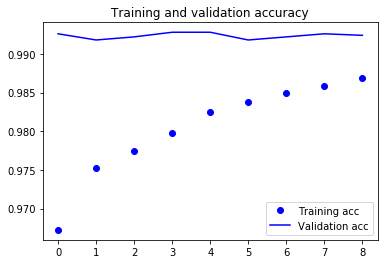

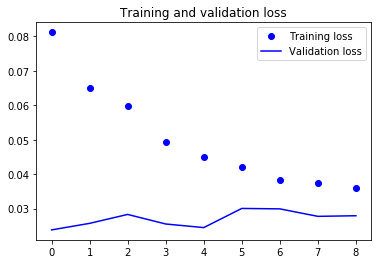

In [24]:
acc = history.history['acc']
val_acc = history.history['val_acc']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'bo', label='Training acc')
plt.plot(epochs, val_acc, 'b', label='Validation acc')
plt.title('Training and validation accuracy')
plt.legend()

plt.figure()

plt.plot(epochs, loss, 'bo', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()

In [27]:
test_generator = test_datagen.flow_from_directory(
        test_dir,
        target_size=(299, 299),
        batch_size=100,
        class_mode=None,
        shuffle=False)

id_batch = test_generator.filenames
print(id_batch[:10])

Found 12500 images belonging to 1 classes.
['test/1.jpg', 'test/10.jpg', 'test/100.jpg', 'test/1000.jpg', 'test/10000.jpg', 'test/10001.jpg', 'test/10002.jpg', 'test/10003.jpg', 'test/10004.jpg', 'test/10005.jpg']


In [28]:
y_pred = model.predict_generator(generator=test_generator,
                                 steps = 125,
                                 workers=1)

In [29]:
y_pred = y_pred.clip(min=0.005, max=0.995)
y_pred = y_pred.reshape(12500,)

In [30]:
from tqdm import tqdm

with open('Inception_V3_Fintuning.csv','w') as f:
    f.write('id,label\n')
    
with open('Inception_V3_Fintuning.csv','a') as f:
    i = 0
    for img_label in tqdm(y_pred):
        img_name = id_batch[i]
        img_id = int(img_name[img_name.rfind('/')+1:img_name.rfind('.')])
        f.write('{},{}\n'.format(img_id,img_label))
        i+=1

100%|██████████| 12500/12500 [00:00<00:00, 469157.32it/s]
